# Sentiment Analysis of Food Reviews

## Import Libraries and Functions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import statistics
mean = statistics.mean
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import DataFunctions as dfs



## Read in the data
Here the data is read into 3 separate dataframes based on the review type.
The data has been previously cleaned for null values and ratings.


In [2]:
# Read in data
df_neutral = pd.read_csv("../Neutral_Reviews.csv")
df_negative = pd.read_csv("../Negative_Reviews.csv")
df_positive = pd.read_csv("../Positive_Reviews.csv")

print(f"There are: \n{len(df_neutral)} neutral reviews \n{len(df_negative)} negative reviews \n{len(df_positive)} positive reviews")

There are: 
40852 neutral reviews 
26937 negative reviews 
1003562 positive reviews


## Sampling
We have a fairly imbalanced dataset so to fix this we can randomly sample 26,000 reviews from each class - which is still plenty of data.

In [3]:
# As few negative reviews I shall sample 26,000 from each dataframe before resetting the index and dropping irrelevant columns.
n = 26000

df_negative = df_negative.sample(n).reset_index().drop(columns=['index','Unnamed: 0','user_id','recipe_id','rating'])
df_neutral = df_neutral.sample(n).reset_index().drop(columns=['index','Unnamed: 0','user_id','recipe_id','rating'])
df_positive = df_positive.sample(n).reset_index().drop(columns=['index','Unnamed: 0','user_id','recipe_id','rating'])


### Assigning Labels
We need to change the reviews from a star rating (1,2,3,4,5) to negative, neutral and positive labels (-1,0,1). Then we can concatenate them into one dataframe.

In [4]:
df_negative['class'] = "Negative"
df_neutral['class']  = "Neutral"
df_positive['class'] = "Positive"
df = df_negative.append(df_neutral).append(df_positive).reset_index().drop(columns=['index'])
df

,review,class
0,Sorry these were not to our taste. They were ...,Negative
1,"Sorry, but this was a big mess! The batter wa...",Negative
2,"I'm not sure if I did something wrong, or what...",Negative
3,Not a very sweet cookie. Wished it was a tad s...,Negative
4,Topping was like crumbs - not sure what happen...,Negative
5,"I'm sorry, but I really didn't enjoy this one ...",Negative
6,"This wa ""ok"" but I think it needed a little mo...",Negative
7,This simple and different recipe for deviled e...,Negative
8,Well.......I just ruined about $20.00 worth of...,Negative
9,This needs a lot for it to even be palatable. ...,Negative


### Visualise Data Stats
This ca be used to determine the maximum and minimum review lengths to check there are no empty reviews and that they are all valid.

In [5]:
# Find lengths (i == review)
negative_lengths = [len(i) for i in df_negative.review]
neutral_lengths  = [len(i) for i in df_neutral.review]
positive_lengths = [len(i) for i in df_positive.review]


/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


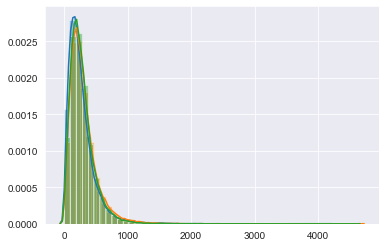

In [6]:
sns.distplot(negative_lengths) # Blue
sns.distplot(neutral_lengths) # Orange
sns.distplot(positive_lengths) # Green

It appears there is a fairly normal distribution if outliers are ignored. 

In [7]:
# Look at average lengths
print(mean(negative_lengths), mean(neutral_lengths), mean(positive_lengths))

267.7572307692308 300.5009615384615 280.75238461538464


The average lengths all seem to sit around the same value too

## Text Cleaning
Here I shall remove punctuation and symbols as well as making each word lowercase. This allows us to analyse the data later on.

In [9]:
# Run our cleaning functions - please see the DataFunctions.py file for the regex syntax used.
df = dfs.clean_text(df, ['review'])

# Sanity check
df.review[0]

'sorry these were not to our taste  they were really eggy  and stange  i cant recomend them even though i loved the ingredient list'

### Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

# Train = 80% ; Test = 20% 
X_train, X_test, y_train, y_test = train_test_split(df['review'],df['class'], test_size=0.2, random_state = 101)

y_train.value_counts() # Check for class imbalance 

Negative    20824
Neutral     20812
Positive    20764
Name: class, dtype: int64

## Create the Corpus
This is essentially all the words in our training dataset - bag of words approach. This part of code creates the corpus of key:value pairs consisting of a token (basically an ID) and a corresponding word. This corpus is then fit to the training and test set, producing a sparse matrix (mostly 0's). What this actually represent is each review as a vector of the words contained in it.
<br> To better demonstrate this: 
<br>example = "This is an example"
<br>corpus = "This is an example of words in a corpus" = [0,1,2,3,4,5,6,7,8]
<br>vector(example) = [1,1,1,1,0,0,0,0,0] . [0,1,2,3,4,5,6,7,8] (Review vector and corresponding corpus tokens)
<br>The above vector is given as it contains 1 of each of the first 4 words in the corpus, but none of the others.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the corpus of words contained within all of our documents - Bag of words
cv = CountVectorizer(binary=True)
cv.fit(X_train)

# Transform reviews into sparse matrix based on words contained in corpus
X_train = cv.transform(X_train)
X_test = cv.transform(X_test)

In [12]:
# All words in corpus.  Key:Value == Words:Token
print((cv.vocabulary_))

{'ive': 18845, 'made': 21139, 'this': 35347, 'twice': 36589, 'once': 24394, 'as': 3945, 'stated': 33209, 'and': 3430, 'with': 38669, 'adjustments': 2668, 'just': 19290, 'didnt': 10918, 'love': 20910, 'it': 18697, 'sorry': 32527, 'want': 37951, 'to': 35758, 'review': 29553, 'again': 2815, 'my': 23213, 'first': 13979, 'one': 24402, 'did': 10900, 'not': 23773, 'look': 20807, 'over': 24875, 'before': 4962, 'sent': 31111, 'spelling': 32792, 'errors': 12803, 'soup': 32588, 'was': 37994, 'wonderful': 38740, 'making': 21283, 'in': 17973, 'the': 35096, 'crock': 9690, 'pot': 26746, 'so': 32275, 'easy': 12118, 'thought': 35460, 'had': 16536, 'frozen': 14887, 'peas': 25656, 'freezer': 14734, 'but': 6472, 'noticed': 23802, 'that': 35059, 'when': 38376, 'added': 2600, 'milk': 22246, 'flour': 14297, 'mixture': 22557, 'thicken': 35248, 'up': 37173, 'really': 28620, 'fast': 13579, 'thanks': 35035, 'for': 14504, 'sharing': 31307, 'recipe': 28714, 'its': 18796, 'best': 5116, 'wanted': 37952, '80s': 2111,

In [13]:
# Sanity Check
(X_train.shape),(X_test.shape),set(y_train)

((62400, 39596), (15600, 39596), {'Negative', 'Neutral', 'Positive'})

## Creating our Models

Below this problem will solved as a multi-class problem. In th

### Decision Tree

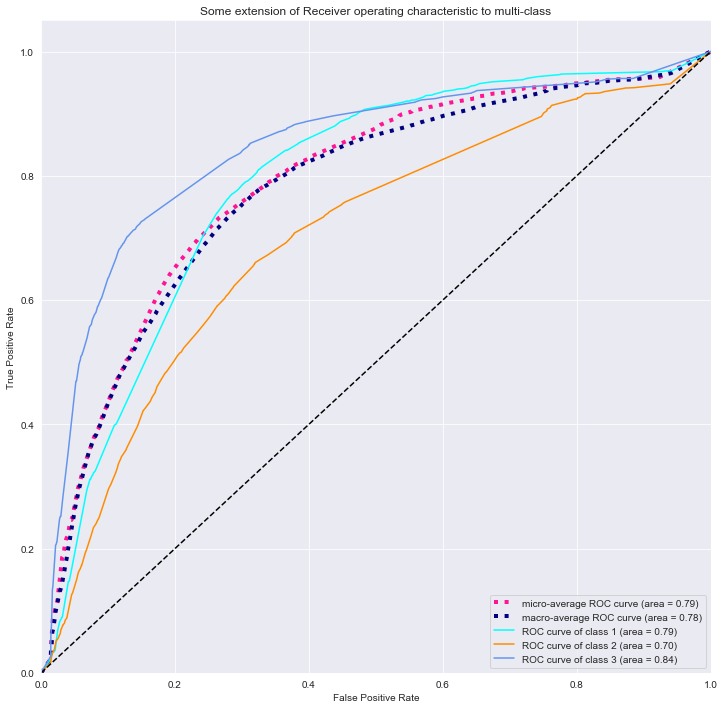

One-vs-Rest ROC AUC scores:
0.775810 (macro),
0.775999 (weighted by prevalence)
None
[[[7287 3137]
  [1108 4068]]

 [[7425 2987]
  [1971 3217]]

 [[8845 1519]
  [1456 3780]]]


In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

list_of_classes = ['Negative','Neutral','Positive']
class_labels = [0,1,2]

clf = DecisionTreeClassifier(criterion='gini', max_depth=15, class_weight='balanced')
clf = dfs.multiclass_classifier(X_train, X_test, y_train, y_test, clf, list_of_classes, class_labels)

### Random Forest

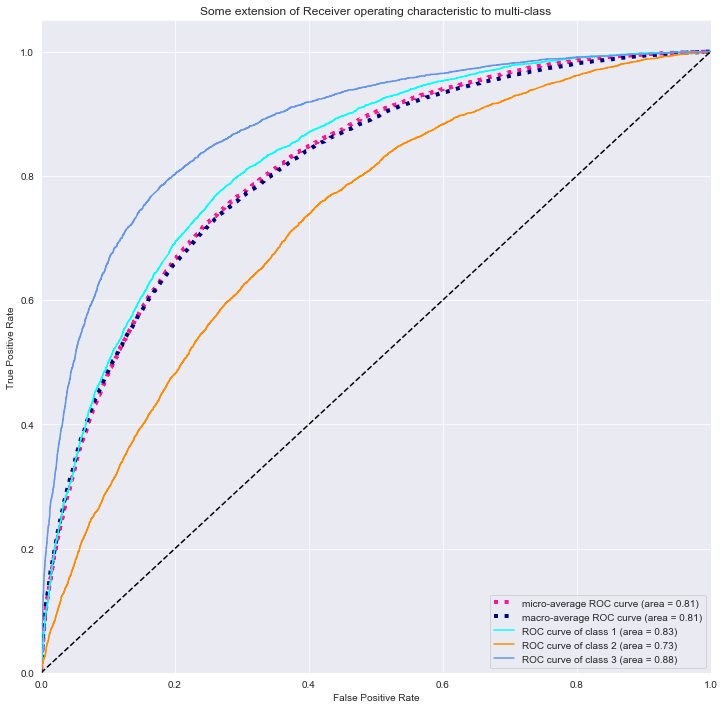

One-vs-Rest ROC AUC scores:
0.810626 (macro),
0.810822 (weighted by prevalence)
None
[[[10306   118]
  [ 4517   659]]

 [[10253   159]
  [ 4818   370]]

 [[10274    90]
  [ 4143  1093]]]


In [21]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

forest = RandomForestClassifier(n_estimators=10, max_depth= 25)
# forest.fit(X_train, y_train)
# y_pred_train = forest.predict(X_train)
# y_pred_val = forest.predict(X_val)
forest = dfs.multiclass_classifier(X_train, X_test, y_train, y_test, forest, list_of_classes, class_labels)

### Logistic Regression

/Users/flatironschool/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


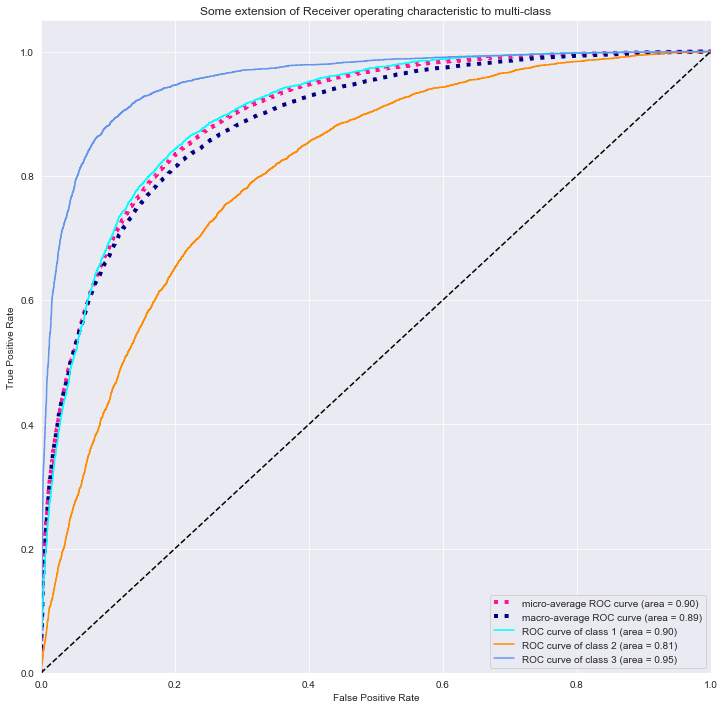

One-vs-Rest ROC AUC scores:
0.887388 (macro),
0.887583 (weighted by prevalence)
None
[[[9322 1102]
  [1539 3637]]

 [[9080 1332]
  [2535 2653]]

 [[9706  658]
  [ 928 4308]]]


In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=0.05)

lr = dfs.multiclass_classifier(X_train, X_test, y_train, y_test, lr, list_of_classes, class_labels)

Logistic Regression provides the best model with the highest ROC AUC scores for classification. Looking carefully at the above plots it is possible to see the ability to classify positive or negative reviews is much easier than classifying neutral ones. This is likely because both positive and negative words appear in a neutral review.

## Inferring from the Model

In [22]:
word_coeff = zip(cv.get_feature_names(), lr.coef_[0])
word_to_coeff = {word: coeff for word, coeff in word_coeff}

most_accurate_positive_words=[]
for best_positive_words in sorted(
    word_to_coeff.items(), 
    key=lambda x: x[1])[:10]:
    most_accurate_positive_words.append(best_positive_words)

print (f"The 10 words as best predictors for a positive review are:\n {most_accurate_positive_words}\n")
    

most_accurate_negative_words=[]    
for best_negative_words in sorted(
    word_to_coeff.items(), 
    key=lambda x: x[1],
    reverse=True)[:10]:
    most_accurate_negative_words.append(best_negative_words)

print (f"The 10 words as best predictors for a negative review are:\n {most_accurate_negative_words}\n")

The 10 words as best predictors for a positive review are:
 [('loved', -1.3226743111535442), ('delicious', -1.2681331251284047), ('excellent', -1.2446736587207199), ('thanks', -1.1284461548033249), ('yummy', -1.0508581181790602), ('yum', -1.0356205604356339), ('thank', -1.0188079586685914), ('perfect', -0.9866098687229113), ('fantastic', -0.9859214590965573), ('wonderful', -0.9492928605208795)]

The 10 words as best predictors for a negative review are:
 [('worst', 1.2539086019003762), ('terrible', 1.220571542574196), ('horrible', 1.13799533800621), ('awful', 1.1130589370450363), ('waste', 1.1127442619276473), ('tasteless', 1.0087464578145857), ('disappointing', 0.9997002395968378), ('gross', 0.9907908824306766), ('sorry', 0.9241308750039607), ('ruined', 0.9032483531199872)]



In [25]:
sorted(word_to_coeff.items(), key=lambda x: x[1],reverse=True)

[('worst', 1.2539086019003762),
 ('terrible', 1.220571542574196),
 ('horrible', 1.13799533800621),
 ('awful', 1.1130589370450363),
 ('waste', 1.1127442619276473),
 ('tasteless', 1.0087464578145857),
 ('disappointing', 0.9997002395968378),
 ('gross', 0.9907908824306766),
 ('sorry', 0.9241308750039607),
 ('ruined', 0.9032483531199872),
 ('inedible', 0.8858449582293962),
 ('disgusting', 0.8490893594930847),
 ('sounded', 0.8290715607890192),
 ('disappointment', 0.8162811957143671),
 ('disappointed', 0.7692871279938249),
 ('wasted', 0.7524190108112875),
 ('flavorless', 0.7395515951703008),
 ('yuck', 0.7372961024607455),
 ('not', 0.7293808996976067),
 ('hated', 0.7138505463531577),
 ('trash', 0.675071995501002),
 ('disaster', 0.6419014241769491),
 ('bland', 0.6389794443243646),
 ('mess', 0.6352631320106902),
 ('smelled', 0.6262826711269214),
 ('throw', 0.6257572232072186),
 ('mush', 0.6147695438984258),
 ('nothing', 0.6039616721142261),
 ('bitter', 0.5884336951686892),
 ('neither', 0.5706175

# Further Processing
As can be seen above, the model performs quite well. There are still ways to try and improve it though. One common technique is to remove stop-words - words such as it/he/she/the/as which distort the frequency of all words in the corpus. It can also be seen that that the best words have repetition (thanks, thank) - this is where Stemming and Lemmatization come in and reduce these "duplicates" down to one word. There are also other factors that could be influencing our data such as phrasing - E.g. where one person has said "loved this recipe" someone else may have said "didn't love it" - a perfect use case for n-grams - a method which allows us to not only look at single words, but also of phrases consisting of n words.


## Stop-Words
I am not sure whether to remove stop words as they may contribute positively to our model in context with n-grams ("loved this recipe" or "didn't love it")

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.word('english')

# print(lr.coef_)

## Stemming

In [ ]:
from nltk.stem.porter import PorterStemmer


## Lemmatization

## TF-IDF and n-grams

# Final Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(binary=True,ngram_range=(1,2))
tfidf.fit(all_reviews_train)

X = tfidf.transform(all_reviews_train)
X_final_test = tfidf.transform(all_reviews_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

target=[]

for i in range(39000):
    if i<13000:
        target.append(2)
    elif 13001<=i<26000:
        target.append(1)
    else:
        target.append(0)

X_train, X_test, y_train, y_test = train_test_split(X, target, train_size = 0.75,random_state=2019)



In [ ]:
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print (f"Accuracy for C={c}: {accuracy_score(y_test, lr.predict(X_test))}")

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
lr = LogisticRegression(C=1)
lr.fit(X_train, target_train)
print (f"Final Accuracy: {accuracy_score(target, lr.predict(X_test))}")


In [ ]:
tfidf.vocabulary_

In [ ]:
word_coeff = zip(tfidf.get_feature_names(), lr.coef_[0])
word_to_coeff = {word: coeff for word, coeff in word_coeff}

most_accurate_positive_words=[]
for best_positive_words in sorted(
    word_to_coeff.items(), 
    key=lambda x: x[1])[:10]:
    most_accurate_positive_words.append(best_positive_words[0])

most_accurate_negative_words=[]    
for best_negative_words in sorted(
    word_to_coeff.items(), 
    key=lambda x: x[1],
    reverse=True)[:10]:
    most_accurate_negative_words.append(best_negative_words[0])
    
print (f"""The 10 words with the highest prediction accuracy for the positive reviews are:
        {most_accurate_positive_words}\n""")

print (f"""The 10 words with the highest prediction accuracy for the negative reviews are:
        {most_accurate_negative_words}\n""")

In [ ]:
for best_positive in sorted(
    word_to_coeff.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)

for best_negative in sorted(
    word_to_coeff.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)